<a href="https://colab.research.google.com/github/Ppangchon/project/blob/main/modeltranin7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelOCT 

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL
import plotly
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

## เตรียมชุดของข้อมูล

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/focusOCT'  # data เราอยู่โฟล์เดอร์ไหน

In [87]:
batch_size = 16   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [204]:
# Train
train_dir = "/content/drive/My Drive/focusOCT/train"
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=25,
                                   horizontal_flip=True,
                                   vertical_flip=True,)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 468 images belonging to 4 classes.


In [205]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[117 117 117 117]


In [206]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [207]:
# Validation
val_dir ="/content/drive/My Drive/focusOCT/validation"
val_datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range=25,
                                 horizontal_flip=True,
                                 vertical_flip=True,)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 60 images belonging to 4 classes.


In [208]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[15 15 15 15]


## Test

In [209]:
# Test
test_dir ="/content/drive/My Drive/focusOCT/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 60 files belonging to 4 classes.


In [210]:
class_names = test_set.class_names
print(class_names)

['CSC', 'NORMAL', 'PCV', 'VKH']


## Setup และโหลด Dataset

In [211]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [212]:
target_img_shape = (256,256) 
train_dir = "/content/drive/My Drive/focusOCT/train" #train dir
val_dir = "/content/drive/My Drive/focusOCT/validation" #validation dir

## สร้างโมเดล CNN

In [213]:
# โหลด pre-trained model ของ Inception-v3
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3))

model = Sequential()

model.add(base_model) # ตัวฐาน (Pre-trained)
model.add(Flatten())
model.add(Dense(128, activation='relu')) 

model.add(Dense(64, activation='relu')) 

model.add(Dense(4, activation='softmax')) # 4 คลาส

model.summary() # ดูสรุป

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 73728)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               9437312   
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 31,248,612
Trainable params: 31,214,180
Non-trainable params: 34,432
_________________________________________________________________


In [214]:
base_model.trainable = False # Freeze ส่วนที่เป็นฐาน (ResNet50)

In [215]:
print("Trainable..\n---")
for variable in model.trainable_variables:
  print(variable.name)

Trainable..
---
dense_15/kernel:0
dense_15/bias:0
dense_16/kernel:0
dense_16/bias:0
dense_17/kernel:0
dense_17/bias:0


ตรวจสอบด้วย .summary() อีกครั้งจะพบว่า Trainable ลดลงเท่ากับการ Freeze มีผลแล้ว

In [216]:
model.summary() # ดูสรุป

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 73728)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               9437312   
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 31,248,612
Trainable params: 9,445,828
Non-trainable params: 21,802,784
_________________________________________________________________


### Compile และ Train

In [217]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [218]:
from keras.api._v2.keras import callbacks
import time

start = time.time()

history = model.fit(train_set,
                    validation_data=val_set, 
                    epochs=20,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
30/30 [==============================] - 112s 3s/step - loss: 7.9534 - accuracy: 0.3675 - val_loss: 3.1106 - val_accuracy: 0.5833
Epoch 2/20
30/30 [==============================] - 103s 3s/step - loss: 2.6607 - accuracy: 0.4936 - val_loss: 2.3432 - val_accuracy: 0.5500
Epoch 3/20
30/30 [==============================] - 96s 3s/step - loss: 1.6345 - accuracy: 0.6261 - val_loss: 1.8109 - val_accuracy: 0.5667
Epoch 4/20
30/30 [==============================] - 101s 3s/step - loss: 1.1051 - accuracy: 0.7051 - val_loss: 2.3533 - val_accuracy: 0.5333
Epoch 5/20
30/30 [==============================] - 101s 3s/step - loss: 1.1762 - accuracy: 0.7179 - val_loss: 2.3476 - val_accuracy: 0.5333
Epoch 6/20
30/30 [==============================] - 91s 3s/step - loss: 0.8255 - accuracy: 0.7479 - val_loss: 2.9359 - val_accuracy: 0.5167
Epoch 7/20
30/30 [==============================] - 100s 3s/step - loss: 1.0929 - accuracy: 0.7158 - val_loss: 2.8052 - val_accuracy: 0.5167
Epoch 8/20
30/3

### Save Model

In [219]:
modelOCT = '/Model'
if not os.path.exists(path+modelOCT):
    os.makedirs(path+modelOCT)
os.makedirs('/content/drive/My Drive/focusOCT/savemodel/', exist_ok=True)
model.save('/content/drive/MyDrive/focusOCT/savemodel/modelOCTin7.h5')

with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='modelOCTin7.h5'
model.save(filepath)
filepath_model = 'modelOCTin7.json'
filepath_weights = 'weightsmodelOCTin7.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weightsmodelOCTin7.h5')
print("Saved model to disk")
     

Saved model to disk


### Load Model

In [220]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 73728)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               9437312   
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 31,248,612
Trainable params: 9,445,828
Non-trainable params: 21,802,784
_________________________________________________________________
Loaded model from disk


## ประเมิน

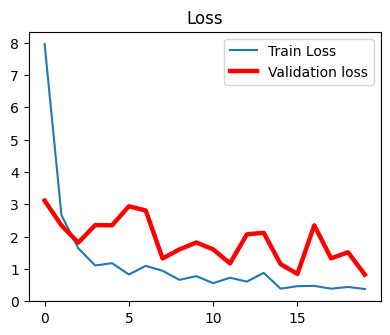

In [221]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

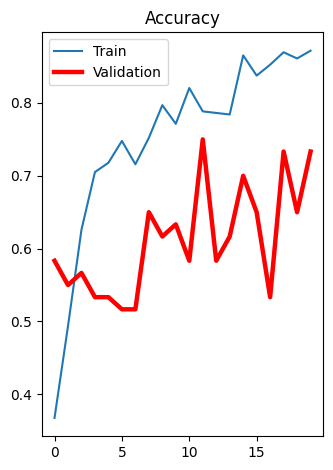

In [222]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [223]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.683


### Prediction

In [47]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image
from keras.models import load_model

In [48]:
train_set.class_indices

{'CSC': 0, 'NORMAL': 1, 'PCV': 2, 'VKH': 3}

1/1 [==============================] - 2s 2s/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) NORMAL tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.1748777, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


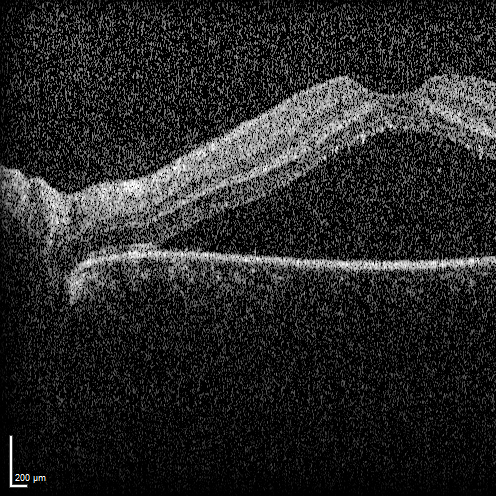

AI VKH มีความมั่นใจ 47.54%.


In [49]:
# CSC
test_path = ('/content/drive/My Drive/focusOCT/test/CSC/JS3524 29-01-18 LE_001_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 192ms/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) NORMAL tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.1748777, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


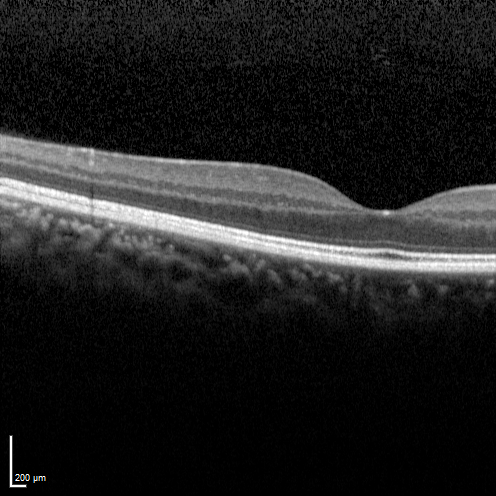

AI VKH มีความมั่นใจ 47.54%.


In [50]:
# NORMAL
test_path = ('/content/drive/My Drive/focusOCT/test/NORMAL/KJ5541 20-07-22 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 181ms/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) NORMAL tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.1748777, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


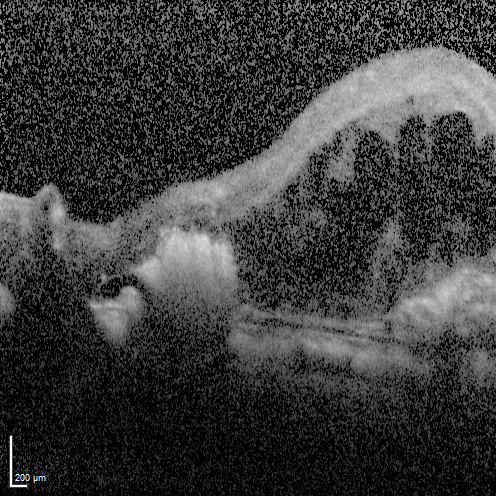

AI VKH มีความมั่นใจ 47.54%.


In [51]:
# PCV
test_path = ('/content/drive/My Drive/focusOCT/test/PCV/JU5423 01-08-18 LE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 173ms/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) NORMAL tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.1748777, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


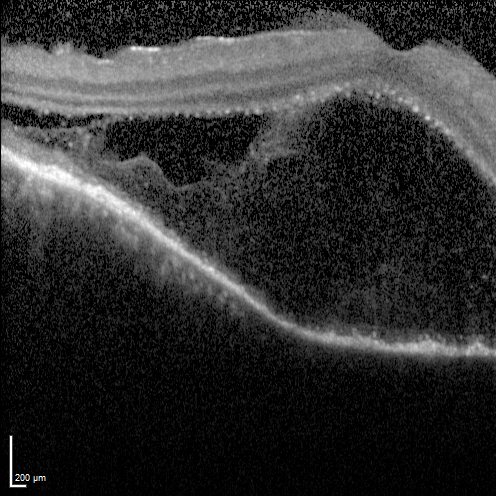

AI VKH มีความมั่นใจ 47.54%.


In [52]:
# VKH
test_path = ('/content/drive/My Drive/focusOCT/test/VKH/KB1074 25-09-19 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [224]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "NORMAL"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 172ms/step


In [225]:
print(y_test)
print(len(y_test))

['CSC', 'VKH', 'PCV', 'PCV', 'CSC', 'VKH', 'PCV', 'VKH', 'PCV', 'VKH', 'PCV', 'PCV', 'NORMAL', 'VKH', 'CSC', 'PCV', 'VKH', 'PCV', 'NORMAL', 'CSC', 'VKH', 'NORMAL', 'VKH', 'CSC', 'NORMAL', 'CSC', 'PCV', 'NORMAL', 'CSC', 'NORMAL', 'PCV', 'CSC', 'NORMAL', 'CSC', 'VKH', 'CSC', 'CSC', 'CSC', 'VKH', 'NORMAL', 'CSC', 'VKH', 'NORMAL', 'VKH', 'VKH', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'CSC', 'PCV', 'NORMAL', 'PCV', 'CSC', 'PCV', 'VKH', 'PCV', 'PCV', 'VKH', 'NORMAL']
60


In [226]:
print(y_pred)
print(len(y_pred))

['NORMAL', 'VKH', 'VKH', 'VKH', 'VKH', 'NORMAL', 'NORMAL', 'VKH', 'VKH', 'VKH', 'VKH', 'VKH', 'VKH', 'NORMAL', 'NORMAL', 'NORMAL', 'VKH', 'VKH', 'NORMAL', 'CSC', 'NORMAL', 'VKH', 'NORMAL', 'VKH', 'VKH', 'VKH', 'NORMAL', 'VKH', 'VKH', 'VKH', 'NORMAL', 'VKH', 'VKH', 'NORMAL', 'NORMAL', 'NORMAL', 'VKH', 'VKH', 'VKH', 'NORMAL', 'NORMAL', 'CSC', 'VKH', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'VKH', 'VKH', 'VKH', 'NORMAL', 'VKH', 'VKH', 'VKH', 'NORMAL', 'VKH', 'VKH', 'NORMAL', 'VKH', 'VKH']
60


## Confusion Matrix

In [227]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [228]:
confusion_matrix(y_test, y_pred)

array([[ 1,  5,  0,  9],
       [ 0,  4,  0, 11],
       [ 0,  7,  0,  8],
       [ 1,  7,  0,  7]])

In [229]:
cm = confusion_matrix(y_test, y_pred)

In [230]:
test_set.class_names

['CSC', 'NORMAL', 'PCV', 'VKH']

In [231]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'NORMAL', 'PCV', 'VKH'], 
                     columns = ['CSC', 'NORMAL', 'PCV', 'VKH'])

In [232]:
cm_df

,CSC,NORMAL,PCV,VKH
CSC,1,5,0,9
NORMAL,0,4,0,11
PCV,0,7,0,8
VKH,1,7,0,7


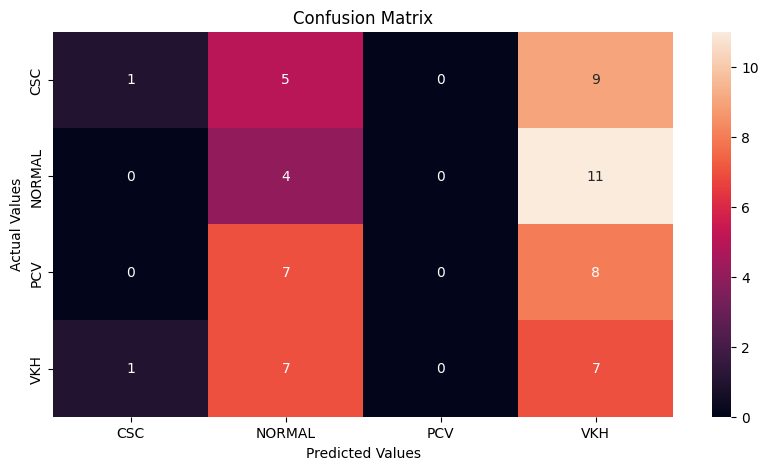

In [233]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

##  misclassify

In [234]:
# แสดง misclassify ว่ามีกี่ค่า
misclassify = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            misclassify += cm[i][j]
            
print('misclassification: ', misclassify)

misclassification:  48


In [235]:
# คำนวณค่า misclassification
misclassify = 1 - np.trace(cm) / np.sum(cm)

# Misclassification rate = จำนวนภาพที่ถูกจัดหมวดหมู่ผิด / จำนวนภาพทั้งหมดที่ใช้ในการทดสอบ

# แสดงผลลัพธ์ที่คิดเป็น %
print("Misclassification: {:.2f}%".format(misclassify*100))

Misclassification: 80.00%


In [236]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [237]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.200000


In [238]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.200000


In [239]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.218478


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [240]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.152043
